In [ ]:
'''
自适应调整多分类二分类
'''

Fold 1:
Accuracy: 0.9348, AUC: 0.9712

Fold 2:
Accuracy: 0.9130, AUC: 0.9258

Fold 3:
Accuracy: 0.9565, AUC: 0.9861

Fold 4:
Accuracy: 0.9111, AUC: 0.9241

Fold 5:
Accuracy: 0.9111, AUC: 0.9602

Average Accuracy: 0.9253
Average AUC: 0.9535


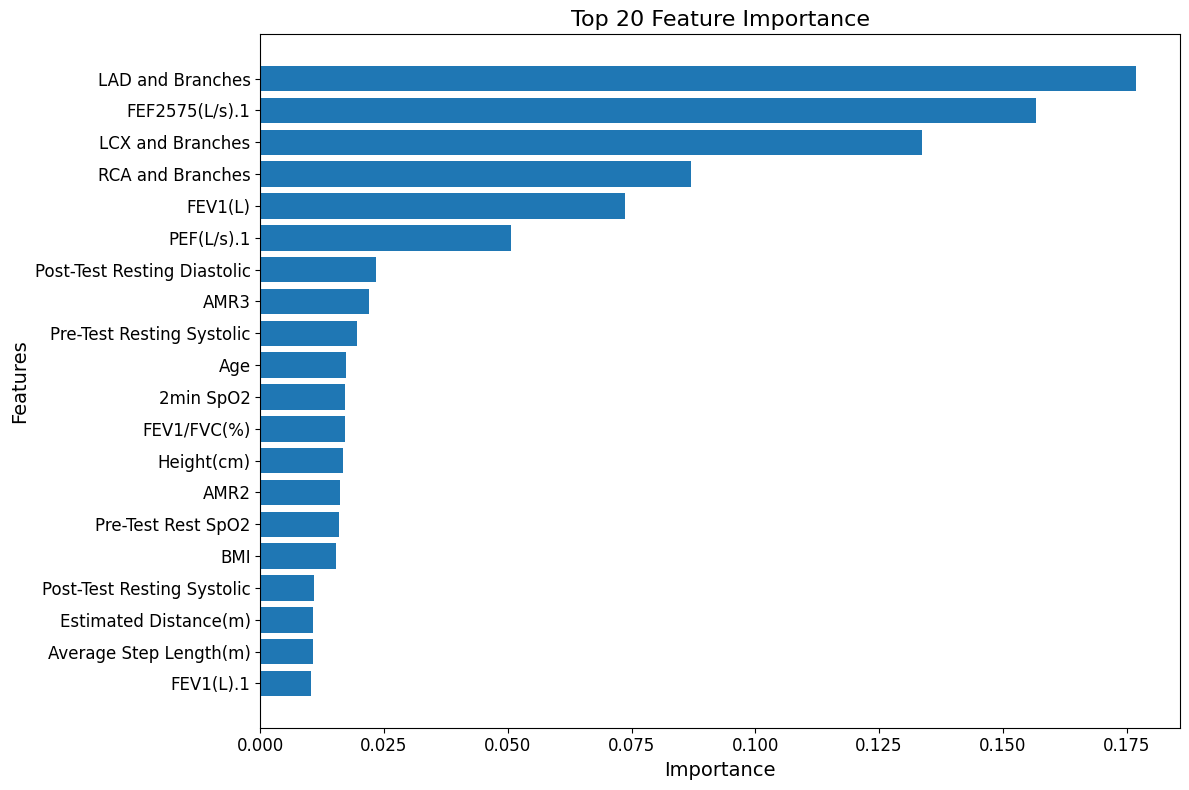


SHAP Analysis:


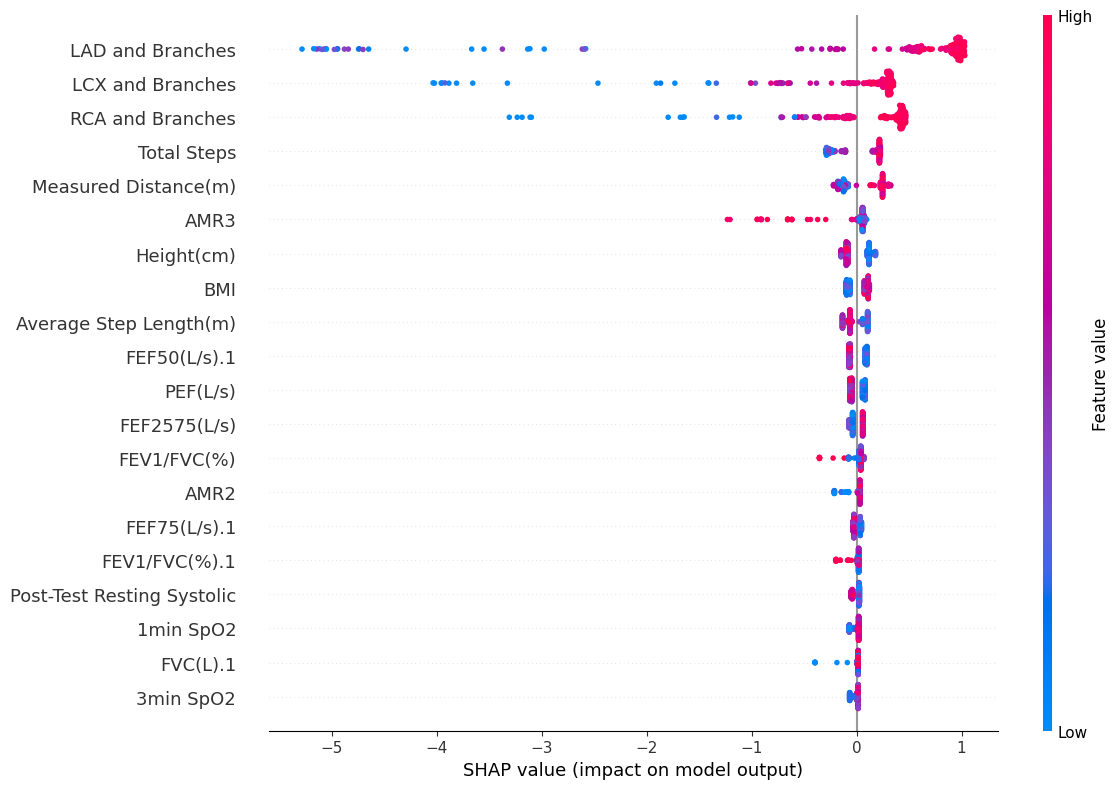

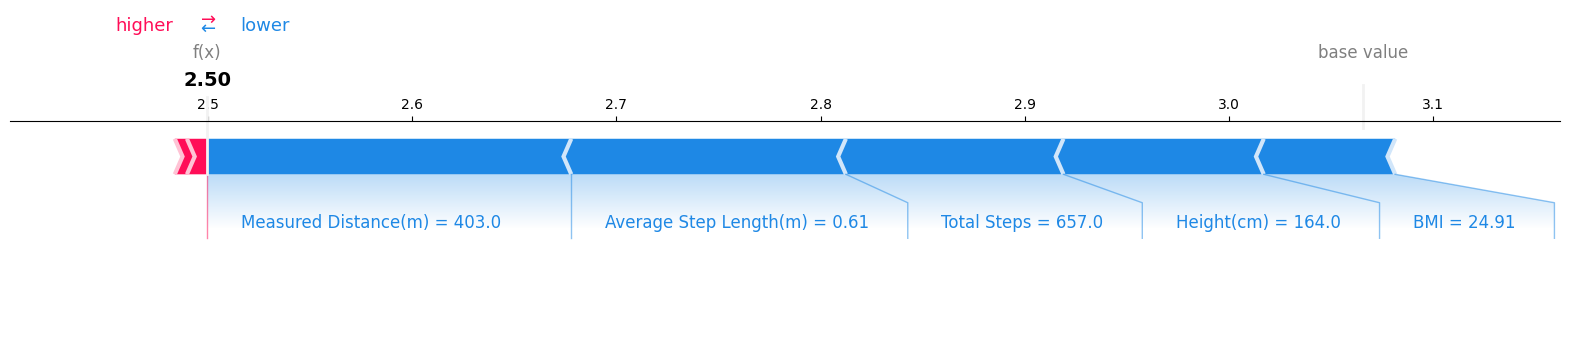

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt

# 读取数据
file_path = "filled_results.xlsx"
df = pd.read_excel(file_path)

# 设置标签列和特征列
target_columns = ['Coronary Artery Myocardial Bridge', 'CHD', 'High-Risk CHD', 'Vessel']
unused_columns = ['Lesion Description', 'Test Start Time', 'Test End Time']
id_column = 'ID'

# 提取特征列
feature_columns = [col for col in df.columns if col not in target_columns + unused_columns + [id_column]]

# 选择目标列（可以根据任务修改目标列）
target_column = 'Vessel'

# 提取特征和目标
X = df[feature_columns]
y = df[target_column]

# 是否保留 ID：这里用于 5 折交叉验证时分组
groups = df[id_column]

# 检查目标变量的类别数
num_classes = len(np.unique(y))

# 初始化 5 折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# 存储每折的结果
fold_accuracies = []
fold_auc_scores = []

# 遍历每折
for train_index, test_index in kf.split(X, y):
    print(f"Fold {fold}:")

    # 划分训练集和测试集
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 初始化 XGBoost 模型
    model = XGBClassifier(
        random_state=42,
        eval_metric="logloss" if num_classes == 2 else "mlogloss"  # 自动选择评估指标
    )

    # 训练模型
    model.fit(X_train, y_train)

    # 预测
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # 计算准确率
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    # 计算 AUC，根据分类任务类型自动调整
    if num_classes == 2:
        # 二分类任务
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])  # 使用第二列的概率
    else:
        # 多分类任务
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 使用 one-vs-rest 模式
    fold_auc_scores.append(auc)

    print(f"Accuracy: {acc:.4f}, AUC: {auc:.4f}\n")
    fold += 1

# 输出总体结果
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Average AUC: {np.mean(fold_auc_scores):.4f}")

# 特征重要性排序
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)  # 重要性升序排列，便于条形图从上到下展示最高重要性

# 绘制特征重要性图
plt.figure(figsize=(12, 8))  # 增大图像尺寸
top_n_features = 20  # 只显示前20个特征
plt.barh(importance_df['Feature'][-top_n_features:], 
         importance_df['Importance'][-top_n_features:], 
         align='center')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top {} Feature Importance'.format(top_n_features), fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'{target_column}_feature_importance.png', dpi=800)
plt.show()

# SHAP 分析
print("\nSHAP Analysis:")
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Summary plot
if num_classes > 2:
    # 多分类任务，选择某个类别（例如类别 0）
    class_index = 0  # 修改为要查看的类别索引
    shap_values_class = shap_values[..., class_index]  # 提取指定类别的 SHAP 值
    shap.summary_plot(shap_values_class, X, plot_size=(12, 8), show=False)  # 调整图表大小
else:
    # 二分类任务，直接绘制
    shap.summary_plot(shap_values, X, plot_size=(12, 8), show=False)  # 调整图表大小

# 保存 Summary Plot
plt.savefig(f'{target_column}_shap_summary.png', dpi=800)  # 保存图片，DPI=800
plt.show()

# 修复 Force Plot 图问题
shap.initjs()  # 初始化 SHAP 的 JS 支持

# 针对多分类任务修正 SHAP Force Plot
if num_classes > 2:
    # 选择类别 0 的 SHAP 值进行可视化
    class_index = 0  # 修改为要查看的类别索引
    shap.force_plot(
        explainer.expected_value[class_index],  # 类别 0 的基值
        shap_values.values[:, :, class_index][0][:10],  # 类别 0 的 SHAP 值（第一个样本）
        X.iloc[0][:10],  # 特征值
        matplotlib=True
    )
else:
    # 二分类任务
    shap.force_plot(
        explainer.expected_value, 
        shap_values.values[0][:10], 
        X.iloc[0][:10], 
        matplotlib=True
    )


In [ ]:
'''
绘制 ROC 曲线
'''

Fold 1:
Accuracy: 0.9348, AUC: 0.9279

Fold 2:
Accuracy: 0.9783, AUC: 0.9760

Fold 3:
Accuracy: 0.9783, AUC: 0.9790

Fold 4:
Accuracy: 1.0000, AUC: 1.0000

Fold 5:
Accuracy: 0.9333, AUC: 0.8981


Plotting ROC Curve...


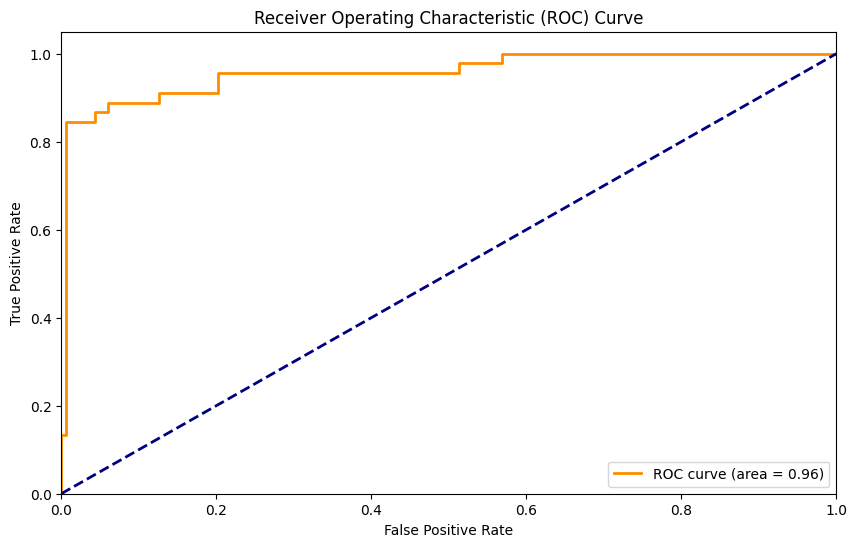

Average Accuracy: 0.9649
Average AUC: 0.9562


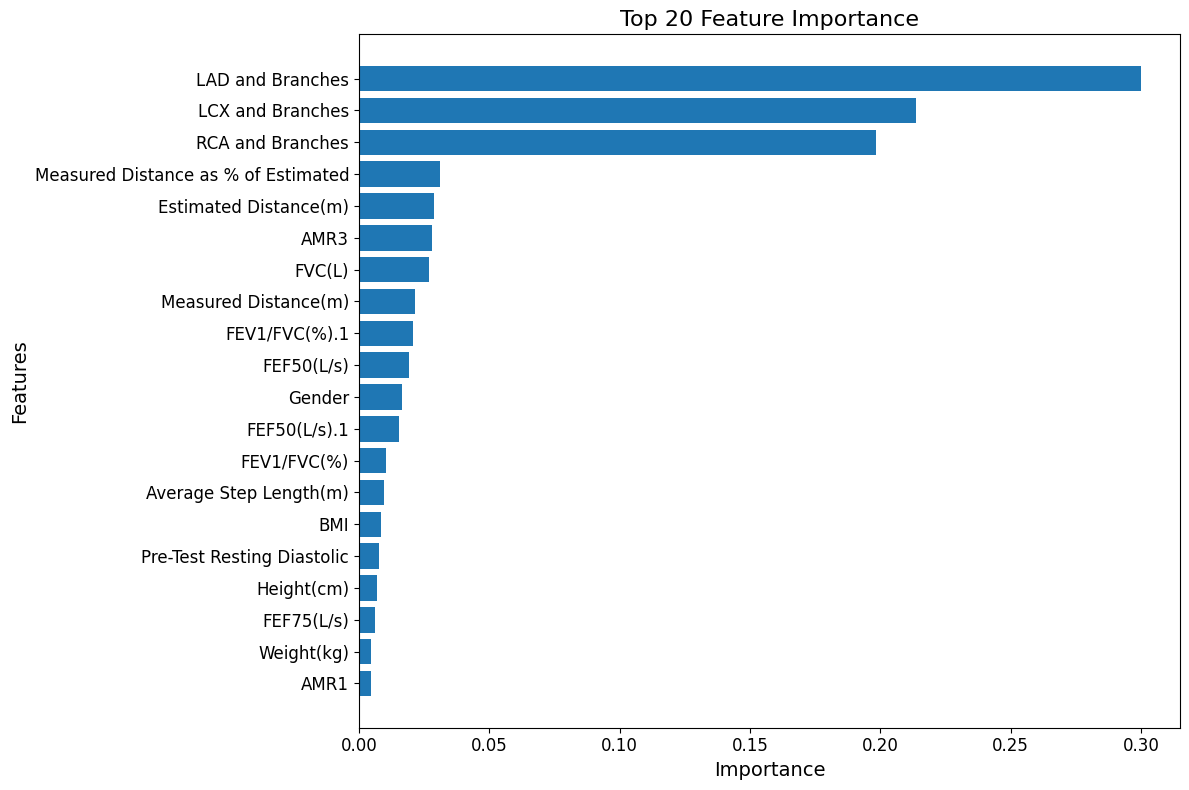


SHAP Analysis:


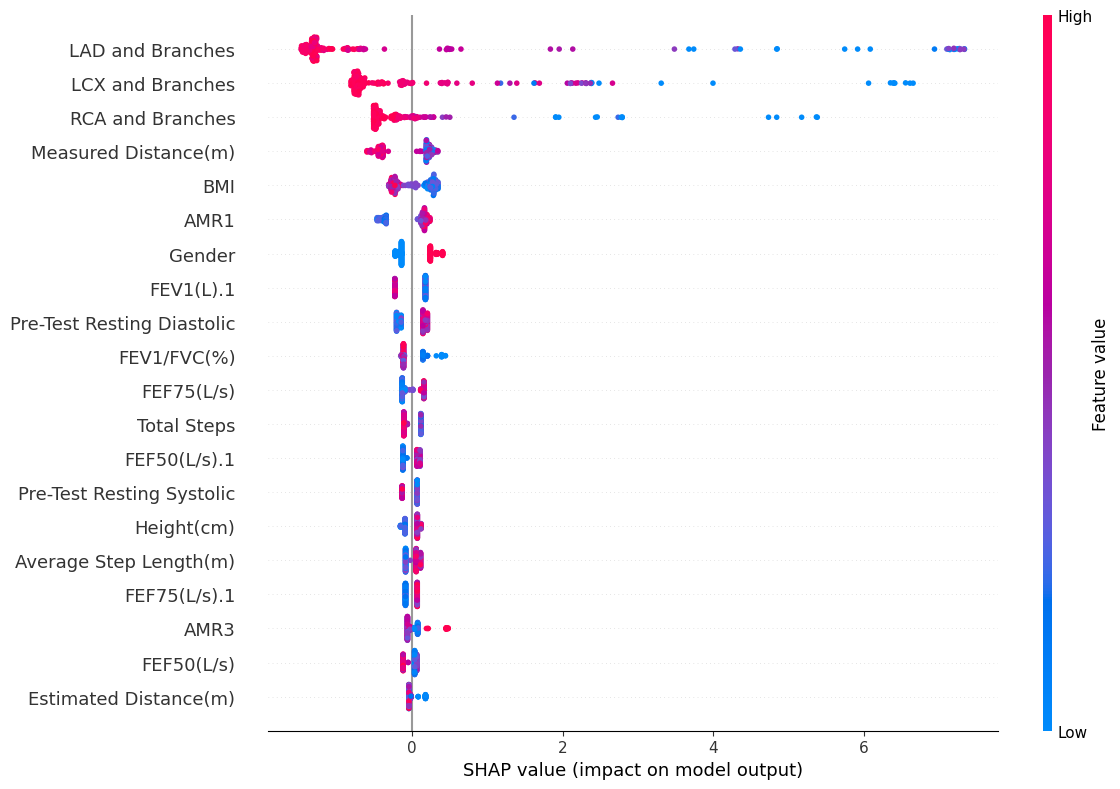

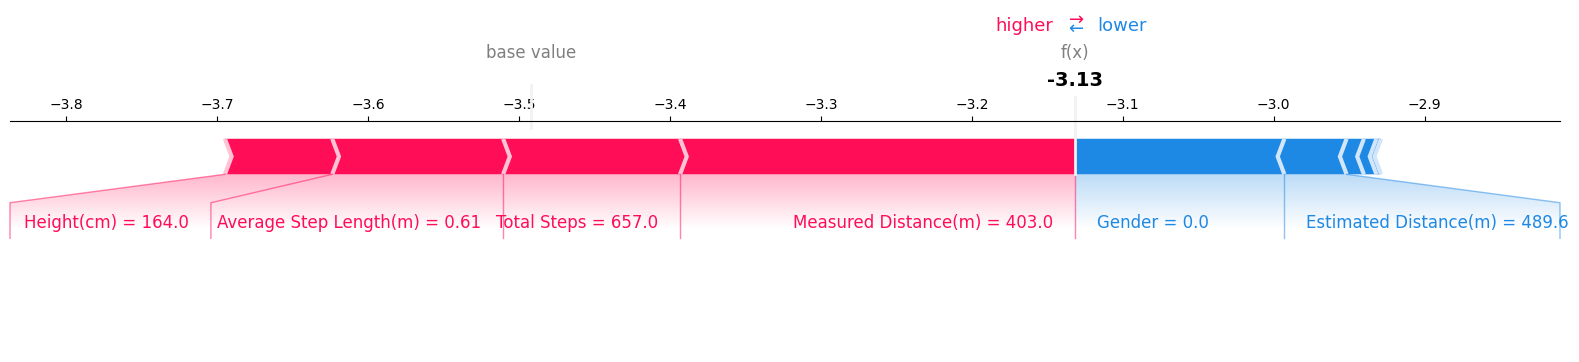

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import shap
import matplotlib.pyplot as plt

# 读取数据
file_path = "6MWT_mts_version.xlsx"
df = pd.read_excel(file_path)

# 设置标签列和特征列
target_columns = ['Coronary Artery Myocardial Bridge', 'CHD', 'High-Risk CHD', 'Vessel']
unused_columns = ['Lesion Description', 'Test Start Time', 'Test End Time']
id_column = 'ID'

# 提取特征列
feature_columns = [col for col in df.columns if col not in target_columns + unused_columns + [id_column]]

# 选择目标列（可以根据任务修改目标列）
target_column = 'High-Risk CHD'

# 提取特征和目标
X = df[feature_columns]
y = df[target_column]

# 是否保留 ID：这里用于 5 折交叉验证时分组
groups = df[id_column]

# 检查目标变量的类别数
num_classes = len(np.unique(y))

# 初始化 5 折交叉验证
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

# 存储每折的结果
fold_accuracies = []
fold_auc_scores = []

# 用于绘制 ROC 曲线
all_y_test = []
all_y_pred_proba = []

# 遍历每折
for train_index, test_index in kf.split(X, y):
    print(f"Fold {fold}:")

    # 划分训练集和测试集
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 初始化 XGBoost 模型
    model = XGBClassifier(
        random_state=42,
        eval_metric="logloss" if num_classes == 2 else "mlogloss"  # 自动选择评估指标
    )

    # 训练模型
    model.fit(X_train, y_train)

    # 预测
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # 记录测试集和预测概率
    all_y_test.append(y_test)
    all_y_pred_proba.append(y_pred_proba)

    # 计算准确率
    acc = accuracy_score(y_test, y_pred)
    fold_accuracies.append(acc)

    # 计算 AUC，根据分类任务类型自动调整
    if num_classes == 2:
        # 二分类任务
        auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])  # 使用第二列的概率
    else:
        # 多分类任务
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 使用 one-vs-rest 模式
    fold_auc_scores.append(auc_score)

    print(f"Accuracy: {acc:.4f}, AUC: {auc_score:.4f}\n")
    fold += 1

# 合并所有测试集和预测概率
all_y_test = np.concatenate(all_y_test)
all_y_pred_proba = np.concatenate(all_y_pred_proba)

# 绘制 ROC 曲线
print("\nPlotting ROC Curve...")
if num_classes == 2:
    # 二分类任务
    fpr, tpr, thresholds = roc_curve(all_y_test, all_y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # 确保曲线从 (0, 0) 开始
    if fpr[0] != 0.0 or tpr[0] != 0.0:
        fpr = np.insert(fpr, 0, 0.0)
        tpr = np.insert(tpr, 0, 0.0)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'{target_column}_roc_curve.png', dpi=800)
    plt.show()
else:
    # 多分类任务
    y_test_binarized = label_binarize(all_y_test, classes=np.unique(y))
    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], all_y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # 确保曲线从 (0, 0) 开始
    if fpr["macro"][0] != 0.0 or tpr["macro"][0] != 0.0:
        fpr["macro"] = np.insert(fpr["macro"], 0, 0.0)
        tpr["macro"] = np.insert(tpr["macro"], 0, 0.0)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr["macro"], tpr["macro"], color='darkorange', lw=2,
             label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve (Macro)')
    plt.legend(loc="lower right")
    plt.savefig(f'{target_column}_macro_roc_curve.png', dpi=800)
    plt.show()

# 输出总体结果
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Average AUC: {np.mean(fold_auc_scores):.4f}")

# 特征重要性排序
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=True)  # 重要性升序排列，便于条形图从上到下展示最高重要性

# 绘制特征重要性图
plt.figure(figsize=(12, 8))  # 增大图像尺寸
top_n_features = 20  # 只显示前20个特征
plt.barh(importance_df['Feature'][-top_n_features:], 
         importance_df['Importance'][-top_n_features:], 
         align='center')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top {} Feature Importance'.format(top_n_features), fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f'{target_column}_feature_importance.png', dpi=800)
plt.show()

# SHAP 分析
print("\nSHAP Analysis:")
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Summary plot
if num_classes > 2:
    # 多分类任务，选择某个类别（例如类别 0）
    class_index = 0  # 修改为要查看的类别索引
    shap_values_class = shap_values[..., class_index]  # 提取指定类别的 SHAP 值
    shap.summary_plot(shap_values_class, X, plot_size=(12, 8), show=False)  # 调整图表大小
else:
    # 二分类任务，直接绘制
    shap.summary_plot(shap_values, X, plot_size=(12, 8), show=False)  # 调整图表大小

# 保存 Summary Plot
plt.savefig(f'{target_column}_shap_summary.png', dpi=800)  # 保存图片，DPI=800
plt.show()

# 修复 Force Plot 图问题
shap.initjs()  # 初始化 SHAP 的 JS 支持

# 针对多分类任务修正 SHAP Force Plot
if num_classes > 2:
    # 选择类别 0 的 SHAP 值进行可视化
    class_index = 0  # 修改为要查看的类别索引
    shap.force_plot(
        explainer.expected_value[class_index],  # 类别 0 的基值
        shap_values.values[:, :, class_index][0][:10],  # 类别 0 的 SHAP 值（第一个样本）
        X.iloc[0][:10],  # 特征值
        matplotlib=True
    )
else:
    # 二分类任务
    shap.force_plot(
        explainer.expected_value, 
        shap_values.values[0][:10], 
        X.iloc[0][:10], 
        matplotlib=True
    )
